<style>
/* Inline CSS zum Ändern der Schriftgröße in Jupyter Notebook */
body {
    font-size: 16px; /* Standardtextgröße */
}

h1 {
    font-size: 28px; /* Überschrift 1 Größe */
}

h2 {
    font-size: 24px; /* Überschrift 2 Größe */
}

h3 {
    font-size: 20px; /* Überschrift 3 Größe */
}
</style>

# What causes lung cancer?
Dataset originated from [Kaggle](https://www.kaggle.com/datasets/mysarahmadbhat/lung-cancer?resource=download)

Based on data of 309 individuals the aim is to find correlation and causes for lung cancer. The following features are included in the data set:
- gender
- age
- smoking
- yellow_fingers
- anxiety
- peer_pressure
- chronic disease
- fatigue
- allergy
- wheezing
- alcohol consuming
- coughing
- shortness of breath
- swallowing difficulty
- chest pain

## Strategy for the project: 
- EDA
- Data Analysis
- Data Visualisation
- Machine Learning Models
- Story Telling






In [41]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [42]:
import warnings
# Deactivate Warnings for 'FutureWarning' Klasse
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set option 'use_inf_as_na' to False
pd.set_option('use_inf_as_na', False)

### Preparation of dataframe

In [44]:
# Path to the zip file
zip_file_path = 'lung_cancer_kaggle.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('data_lung_cancer')  # Extract the contents to a folder

# Load the data from the extracted files using pandas
data = pd.read_csv('data_lung_cancer/survey lung cancer.csv')  # Replace 'your_data_file.csv' with the actual file name
#rename columns to lower case
new_cols = []
for col in list(data.columns):
    new_cols.append(col.lower())
data.columns = new_cols
#show dataframe, Dictionary: 1 = NO, 2 = YES
display(data.head())
data.columns #Space at the end of allergy and fatigue
new_cols = ['gender', 'age', 'smoking', 'yellow_fingers', 'anxiety',
       'peer_pressure', 'chronic disease', 'fatigue', 'allergy', 'wheezing',
       'alcohol consuming', 'coughing', 'shortness of breath',
       'swallowing difficulty', 'chest pain', 'lung_cancer']
data.columns = new_cols

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic disease,fatigue,allergy,wheezing,alcohol consuming,coughing,shortness of breath,swallowing difficulty,chest pain,lung_cancer
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [45]:
def label_encoder(first, second, first_sub, second_sub, col_name, df):
    """
    Converts two values in a column of a dataframe into two different values for label encoding.
    
    first, second, first_sub, second_sub (str, int, float): Given values and values to substitute with

    return (dataframe): returns altered dataframe
    """
    df[col_name] = df[col_name].replace({first: first_sub})
    df[col_name] = df[col_name].replace({second: second_sub})
    
    
    return df
    
    


In [46]:
#encode 0 = M, 1 = F
label_encoder("M", "F", 0,1, "gender", data)
#encode 1 to 0, and 2 to 1 for consistency
for col_name in [cols for cols in list(data.columns) if cols not in ["gender", "age", "lung_cancer"]]:
    label_encoder(1,2,0,1,col_name, data)
#encode NO to 0, YES to 1
label_encoder("NO", "YES", 0,1, "lung_cancer", data)

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic disease,fatigue,allergy,wheezing,alcohol consuming,coughing,shortness of breath,swallowing difficulty,chest pain,lung_cancer
0,0,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,0,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,1,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,0,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,1,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,1,56,0,0,0,1,1,1,0,0,1,1,1,1,0,1
305,0,70,1,0,0,0,0,1,1,1,1,1,1,0,1,1
306,0,58,1,0,0,0,0,0,1,1,1,1,0,0,1,1
307,0,67,1,0,1,0,0,1,1,0,1,1,1,0,1,1


### EDA and Data Visualization


In [48]:
data.describe()
#plausible min and max values

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic disease,fatigue,allergy,wheezing,alcohol consuming,coughing,shortness of breath,swallowing difficulty,chest pain,lung_cancer
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,0.475728,62.673139,0.563107,0.569579,0.498382,0.501618,0.504854,0.673139,0.556634,0.556634,0.556634,0.579288,0.640777,0.469256,0.556634,0.873786
std,0.500221,8.210301,0.496806,0.495938,0.500808,0.500808,0.500787,0.469827,0.497588,0.497588,0.497588,0.494474,0.480551,0.499863,0.497588,0.332629
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,62.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,69.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,87.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
data.info()
#no missing values
#correct data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   gender                 309 non-null    int64
 1   age                    309 non-null    int64
 2   smoking                309 non-null    int64
 3   yellow_fingers         309 non-null    int64
 4   anxiety                309 non-null    int64
 5   peer_pressure          309 non-null    int64
 6   chronic disease        309 non-null    int64
 7   fatigue                309 non-null    int64
 8   allergy                309 non-null    int64
 9   wheezing               309 non-null    int64
 10  alcohol consuming      309 non-null    int64
 11  coughing               309 non-null    int64
 12  shortness of breath    309 non-null    int64
 13  swallowing difficulty  309 non-null    int64
 14  chest pain             309 non-null    int64
 15  lung_cancer            309 non-null    i

In [50]:
print(data.duplicated().sum())
data.drop_duplicates(inplace = True)
print(data.duplicated().sum())
data = data.reset_index(drop = True)

33
0


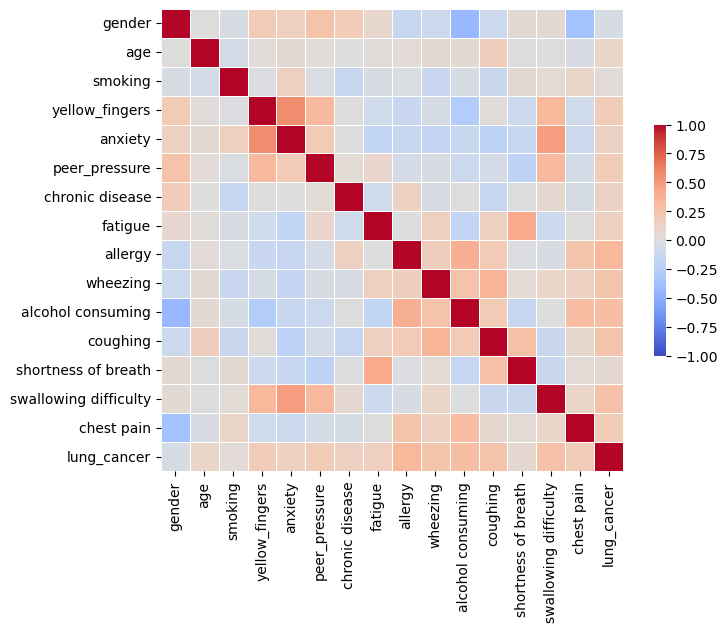

In [51]:
# Compute the correlation matrix
corr = data.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(corr, cmap='coolwarm', vmax=1, vmin =-1, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

#Note: Important to know would be, how long and how much they actually have been smoking

Text(0.5, -0.3, 'Over 80% of the data refer to cancer patients. Non-cancer data is under-represented.')

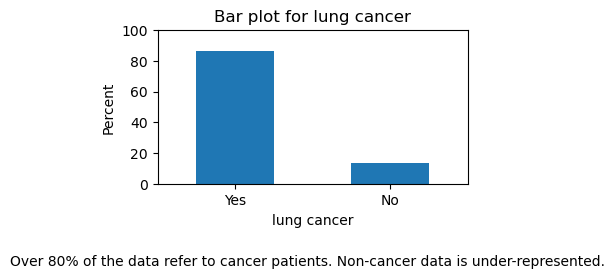

In [196]:
temp_series = data["lung_cancer"].replace({0: 'No', 1: 'Yes'})

column_name = column.replace("_" , " ")
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(4, 2))  # Increase width to make room for the note

# Create a bar plot for the current column
temp_series_count = temp_series.value_counts(normalize=True)*100
temp_series_count.plot(kind='bar', ax=ax)

ax.set_title(f'Bar plot for {column_name}')
ax.set_ylabel('Percent')
ax.set_ylim(0, 100)
ax.tick_params(axis='x', rotation=0)
ax.set_xlabel(column_name)
note = "Over 80% of the data refer to cancer patients. Non-cancer data is under-represented."
# Add note below the plot
fig.text(0.5, -0.3, note, ha='center', fontsize=10)

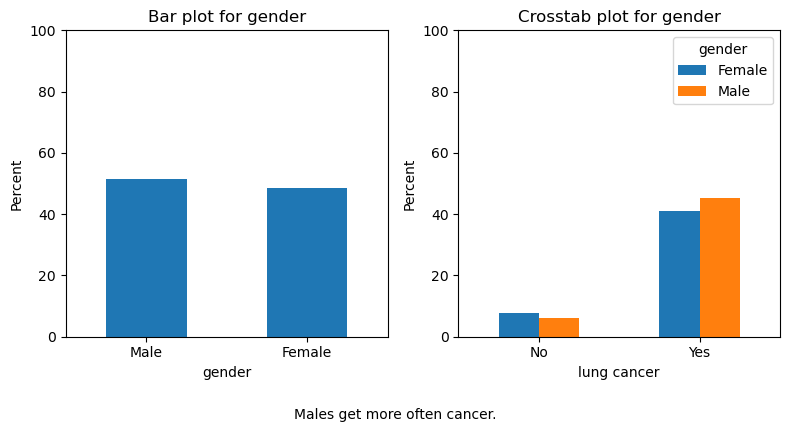

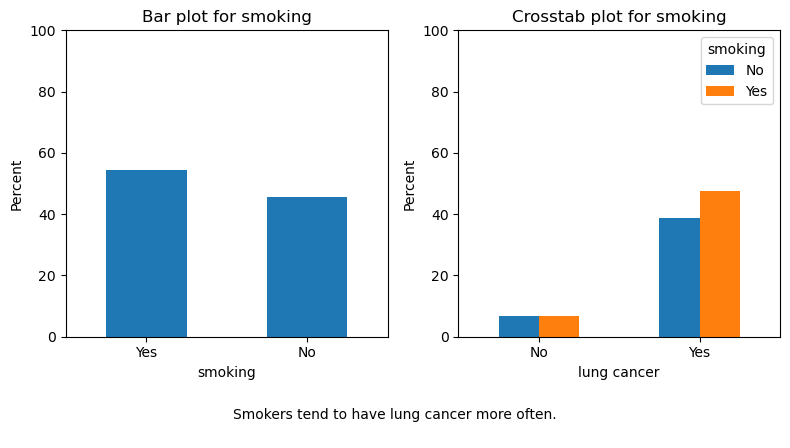

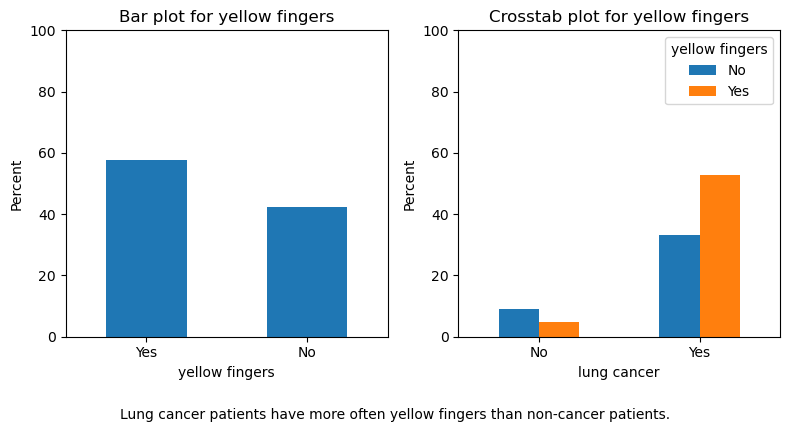

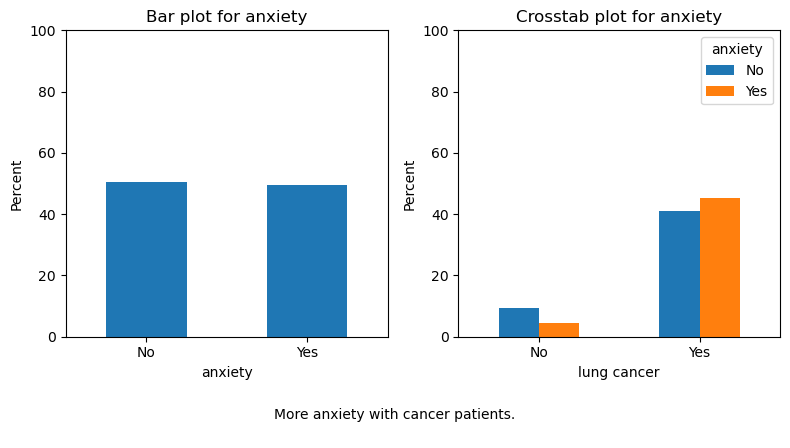

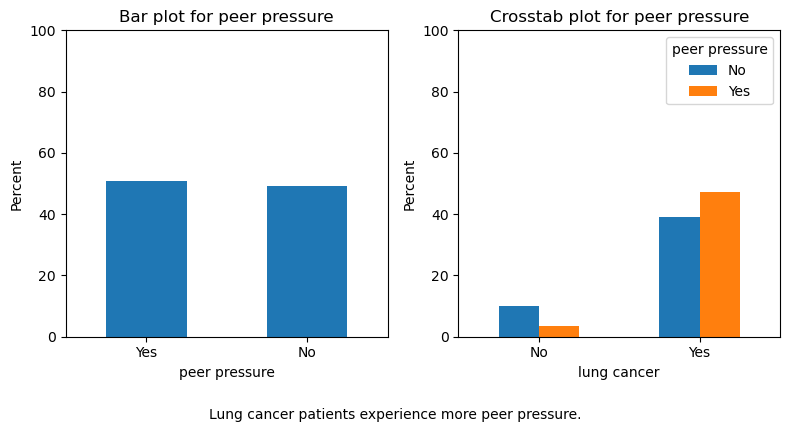

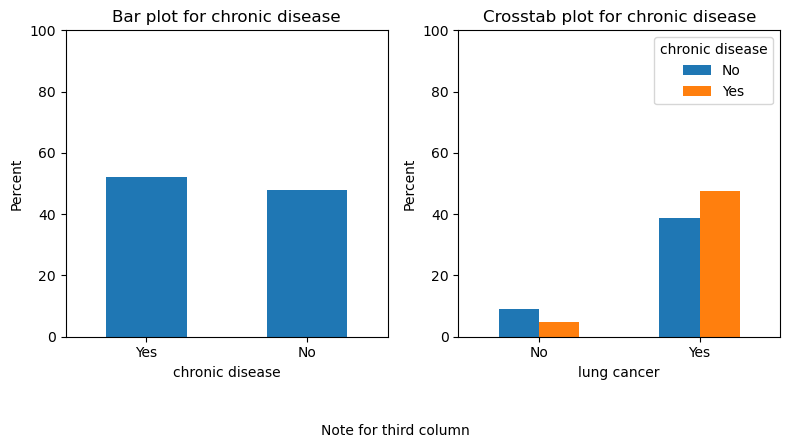

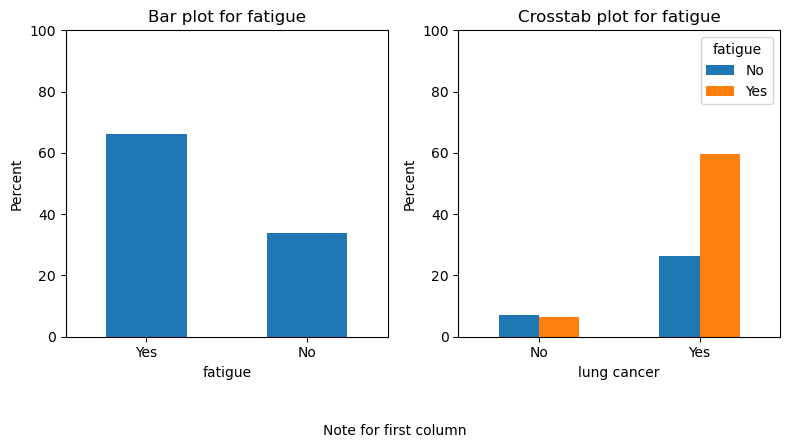

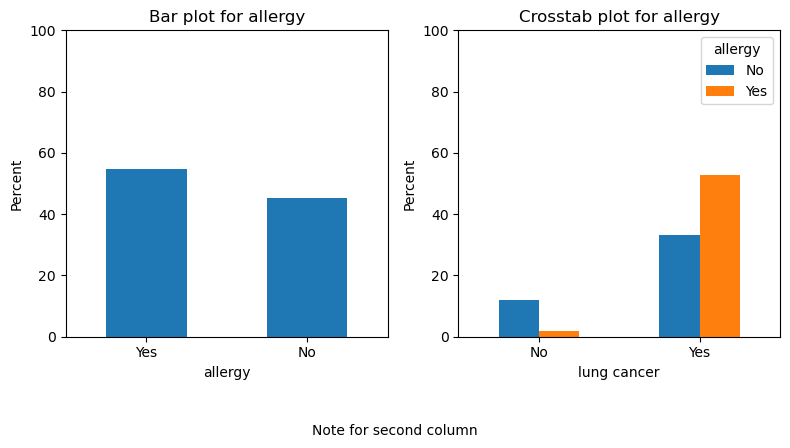

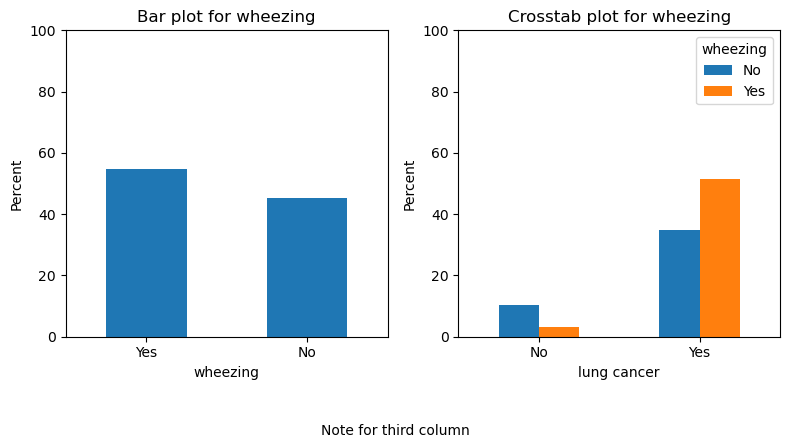

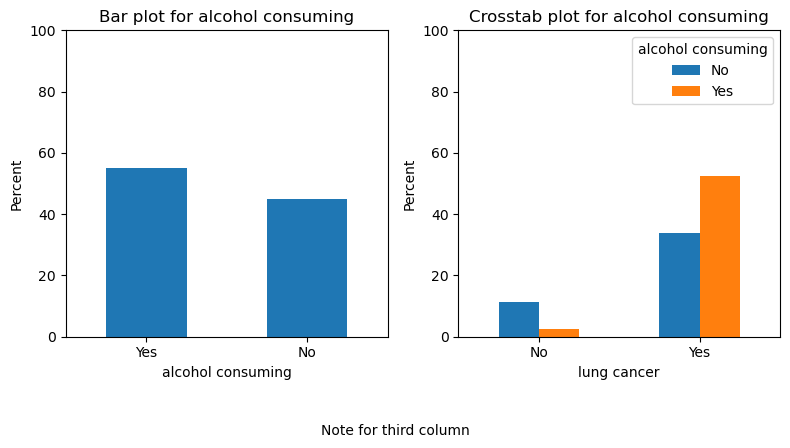

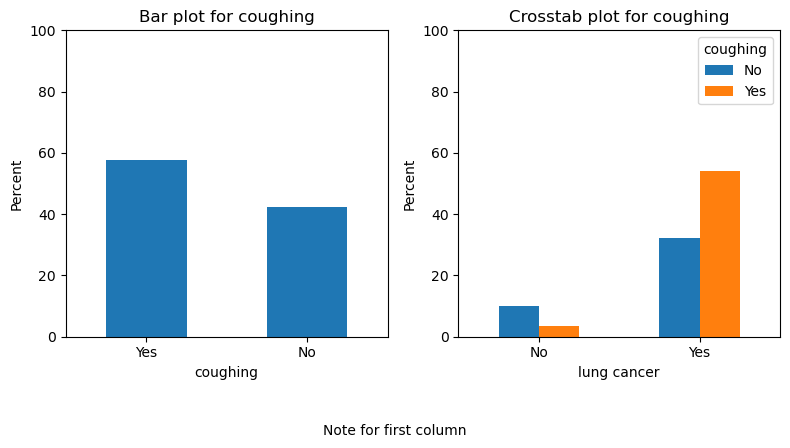

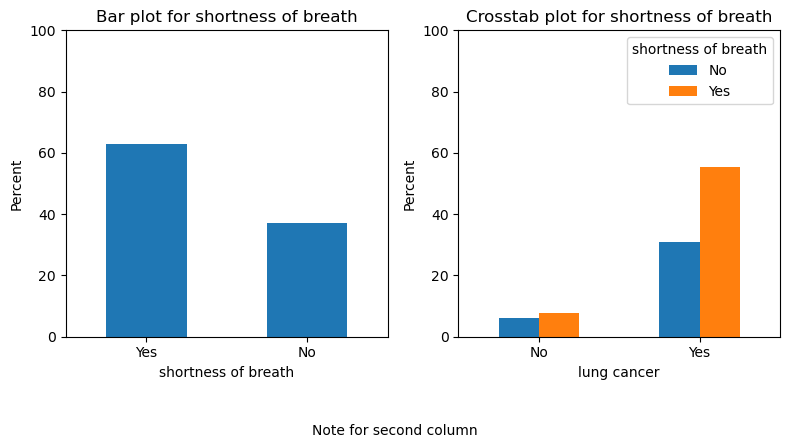

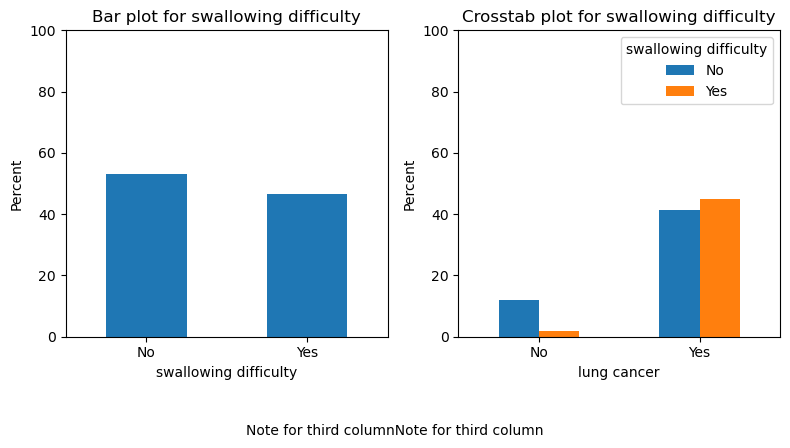

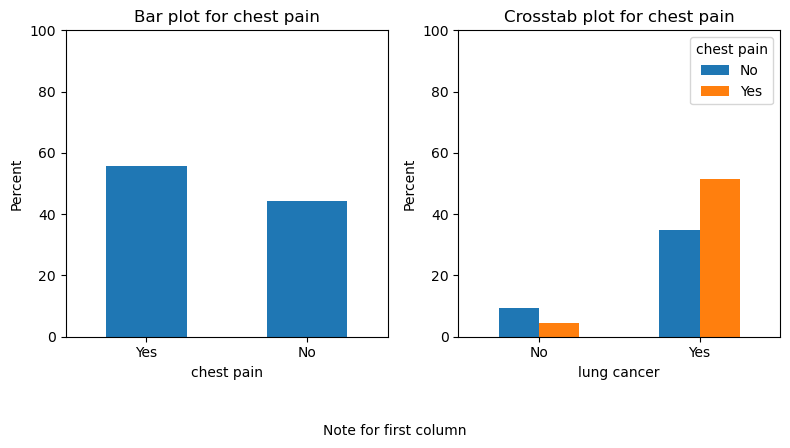

In [182]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and 'notes' is your list of notes
notes = [
    "Males get more often cancer.\n",
    "Placeholder",
    "Smokers tend to have lung cancer more often.\n",
    "Lung cancer patients have more often yellow fingers than non-cancer patients.\n",
    "More anxiety with cancer patients.\n",
    "Lung cancer patients experience more peer pressure.\n",
    "Note for third column",
        "Note for first column",
    "Note for second column",
    "Note for third column",
        "Note for third column",
        "Note for first column",
    "Note for second column",
    "Note for third column"
        "Note for third column",
        "Note for first column",
    "Note for second column",
    "Note for third column"
        "Note for third column",
        "Note for first column",
    "Note for second column",
    "Note for third column"
    # Add more notes as needed
]

# Iterate through the columns and the corresponding notes
for i, column in enumerate(data.columns):
    if column != "age" and column != "lung_cancer":
        if column == "gender":
            temp_series = data[column].replace({0: 'Male', 1: 'Female'})
        else:
            temp_series = data[column].replace({0: 'No', 1: 'Yes'})
        
        column_name = column.replace("_" , " ")
        # Create a figure and a set of subplots
        fig, ax = plt.subplots(figsize=(8, 4), ncols =2)  # Increase width to make room for the note
        
        # Create a bar plot for the current column
        temp_series_count = temp_series.value_counts(normalize=True)*100
        temp_series_count.plot(kind='bar', ax=ax[0])
        
        ax[0].set_title(f'Bar plot for {column_name}')
        ax[0].set_ylabel('Percent')
        ax[0].set_ylim(0, 100)
        ax[0].tick_params(axis='x', rotation=0)
        ax[0].set_xlabel(column_name)

        temp_data = data["lung_cancer"].replace({0: 'No', 1: 'Yes'})
        temp_series_ct = pd.crosstab(index=temp_data, columns=temp_series, normalize = True)*100
        temp_series_ct.plot(kind="bar", ax=ax[1])
        
        ax[1].set_title(f'Crosstab plot for {column_name}')
        ax[1].set_ylabel('Percent')
        ax[1].set_ylim(0, 100)
        ax[1].tick_params(axis='x', rotation=0)
        ax[1].set_xlabel("lung cancer")

        # Update the legend to include the column name in the legend labels
        handles, labels = ax[1].get_legend_handles_labels()
        ax[1].legend(title=column_name)
        
        # Add note below the plot
        fig.text(0.5, -0.1, notes[i], ha='center', fontsize=10)


        plt.tight_layout()
        plt.show()


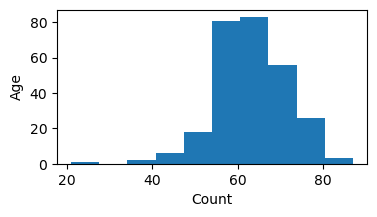

In [81]:
#hier noch Altersverteilung unter cancer



plt.figure(figsize= (4,2))  # Create a new figure for each plot
data["age"].plot(kind='hist')

plt.xlabel("Count")
plt.ylabel('Age')
plt.show()
#somewhat normal distribution

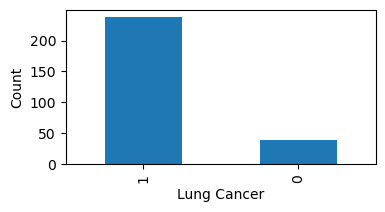

In [65]:
plt.figure(figsize= (4,2))  # Create a new figure for each plot
data["lung_cancer"].value_counts().plot(kind='bar')

plt.xlabel("Lung Cancer")
plt.ylabel('Count')
plt.show()
#Lung Cancer Free is underrepresented. For ML training probelmatic. SMOTE for same sized groups.

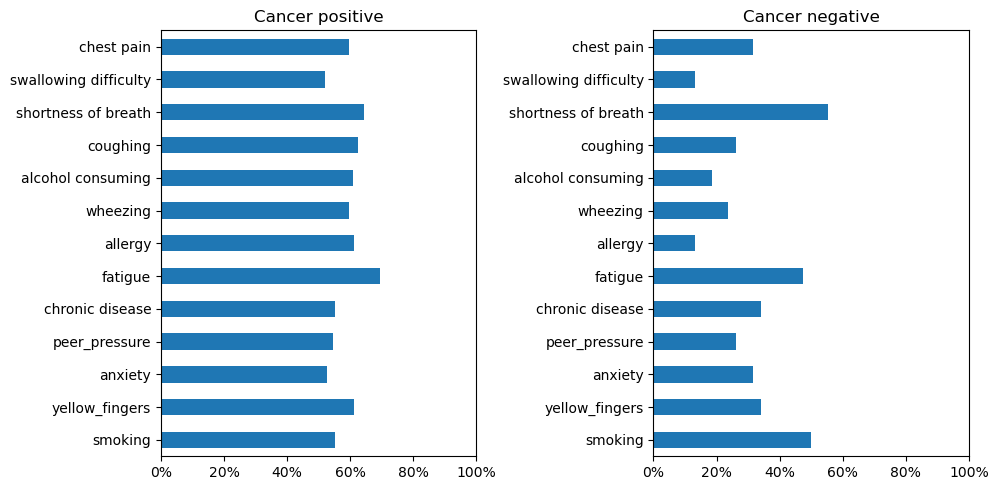

In [15]:
#How many people (in percent) who have lung cancer have/are also ...
data_lung_cancer_positive = data[data["lung_cancer"] ==1]
data_lung_cancer_negative = data[data["lung_cancer"] ==0]

fig, ax = plt.subplots(figsize=(10,5), ncols=2)
data_lung_cancer_positive.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"].plot(kind="barh", ax=ax[0])
data_lung_cancer_negative.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"].plot(kind="barh", ax=ax[1])

#How much more people suffer from symptoms in the cancer group
cancer_to_no_cancer = data_lung_cancer_positive.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"] - data_lung_cancer_negative.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"]


ax[0].set_xlim(0,1)
ax[1].set_xlim(0,1)

ax[0].set_title("Cancer positive")
ax[1].set_title("Cancer negative")

plt.tight_layout()

for axis in ax:
    axis.xaxis.set_major_formatter(mtick.PercentFormatter(1)) 

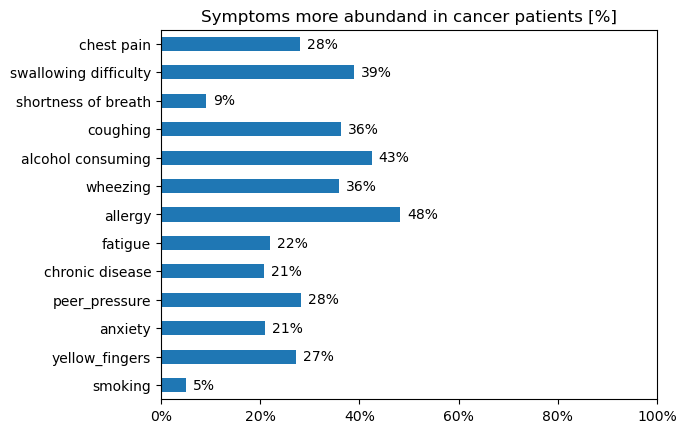

In [16]:
bars = cancer_to_no_cancer.plot(kind="barh", xlim=(0,1))
plt.title("Symptoms more abundand in cancer patients [%]")

for bar in bars.patches:
    plt.annotate(f'{bar.get_width():.0%}',                            
                 xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),  
                 xytext=(5, 0),                                       
                 textcoords='offset points',
                 ha='left', va='center',                              
                 fontsize=10, color='black')

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1)) 

#Only 9% more smokers in the cancer group
#Cancer patients have 49% more allergies
#43% more alcohol consumers in the cancer group --> indicates a overall less healthy lifestile than the non-cancer group. A unhealthy lifestyle can maybe contribute to cancer formation

### Split Dataset to Train and Test Data

In [18]:
from sklearn.model_selection import train_test_split

# Define features and target
features = data.drop('lung_cancer', axis=1)  
target = data['lung_cancer']  

# Split in Train and Test Data
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)
for df in [features_train, features_test, target_train, target_test]:
    print(df.shape)

(193, 15)
(83, 15)
(193,)
(83,)


### SMOTE

In [20]:
pd.crosstab(index=target_train, columns="count")

col_0,count
lung_cancer,
0,25
1,168


In [21]:
#Artificial enlargement of the minority category “no lung cancer”
smotesampler = SMOTE(random_state=42)
features_smote, target_smote = smotesampler.fit_resample(features_train, target_train)
pd.crosstab(index=target_smote, columns="count")

col_0,count
lung_cancer,
0,168
1,168


### Feature Engineering and One Hot Encoding

In [23]:
data["age"]

0      69
1      74
2      59
3      63
4      63
       ..
271    59
272    59
273    55
274    46
275    60
Name: age, Length: 276, dtype: int64

<Axes: xlabel='age'>

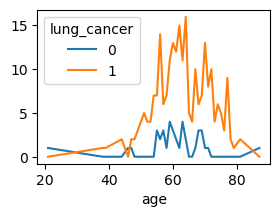

In [24]:
pd.crosstab(index=data["age"], columns=data["lung_cancer"]).plot(figsize=(3,2))
#very little datapoints below 45
#cut main points between 45 and 75 in two groups

In [25]:
def feature_engineering(features):
    """
    Performs feature engineering on the provided DataFrame, including grouping age ranges 
    and applying One-Hot-Encoding to the age group.

    Parameters:
    features (DataFrame): The input data as a Pandas DataFrame. 
                          It should contain an 'age' column and any other feature columns.

    Returns:
    DataFrame: A transformed DataFrame with age groups one-hot encoded and 
               other features remaining unchanged.
    """
    # Group people in 'under 45', 'ages 45-59', 'ages 60-74', '75+'
    mask_under_45 = features["age"] < 45
    mask_45_60 = (features["age"] >= 45) & (features["age"] < 60)
    mask_60_75 = (features["age"] >= 60) & (features["age"] < 75)
    mask_over_75 = features["age"] >= 75

    conditions = [mask_under_45, mask_45_60, mask_60_75, mask_over_75]
    values = ['under 45', 'ages 45-59', 'ages 60-74', '75+']

    features['age_group'] = np.select(conditions, values, default='Unknown')

    # Initialize OneHotEncoder
    ohe = OneHotEncoder(sparse=False)

    # Initialize ColumnTransformer
    columns = ['age_group']
    encoder = ColumnTransformer([("OHE", ohe, columns)], remainder="passthrough")

    # Fit encoder to the features data
    encoder.fit(features)

    # Get feature names for one-hot encoded features
    ohe_names = encoder.named_transformers_["OHE"].get_feature_names_out(columns)
    # Get names of remaining features
    remaining_names = [name for name in features.columns if name not in columns]

    # Combine new column names
    all_names = list(ohe_names) + remaining_names

    # Transform the features data
    features_transformed = encoder.transform(features)

    # Create a DataFrame with the new column names
    features_ohe = pd.DataFrame(features_transformed, columns=all_names)

    return features_ohe


In [26]:
features_train_ohe = feature_engineering(features_train)

features_train["age_group"].value_counts()

age_group
ages 60-74    113
ages 45-59     62
75+            16
under 45        2
Name: count, dtype: int64

In [27]:
# Compute the correlation matrix
df_train = features_train_ohe.copy()
df_train["lung_cancer"] = target_train
corr = df_train.corr()

corr["lung_cancer"]
#correlation age under 45, underrep. group (3 Members), age, swallowing difficulty

age_group_75+            0.012702
age_group_ages 45-59    -0.042577
age_group_ages 60-74     0.023258
age_group_under 45       0.046920
gender                   0.022422
age                     -0.006440
smoking                  0.051011
yellow_fingers           0.034861
anxiety                  0.083900
peer_pressure            0.101812
chronic disease          0.090185
fatigue                 -0.015871
allergy                  0.095981
wheezing                -0.038929
alcohol consuming        0.113594
coughing                -0.095673
shortness of breath     -0.112543
swallowing difficulty    0.033265
chest pain               0.098250
lung_cancer              1.000000
Name: lung_cancer, dtype: float64

In [28]:
features_train.columns

Index(['gender', 'age', 'smoking', 'yellow_fingers', 'anxiety',
       'peer_pressure', 'chronic disease', 'fatigue', 'allergy', 'wheezing',
       'alcohol consuming', 'coughing', 'shortness of breath',
       'swallowing difficulty', 'chest pain', 'age_group'],
      dtype='object')

## Machine Learning Modelle

### Metrics for model evaluation

In [31]:
#We are looking to predict cancer. It is more fatal to miss cancer then to predict cancer, 
#where actually nothing is wrong. Of course, the patient will suffer emotionally, 
#but missing cancer will be more severe for a patient. In this case we want a high Recall. 
#But saying that every patient has cancer is also not good. 
#Therefore precision should also be considered but maybe less weighted.  

def eval_regression(model, features, target):
    """
    Evaluates the trained regression model based on the metrics Accuracy, 
    Precision, Recall and F1 Score

    model (ML model)
    features (df): Features of the test data correspond to those used during training
    target (Series): target of test data

    Returns nothing.
    
    """
    
    target_test_pred = model.predict(features)
    precision = precision_score(target, target_test_pred)
    recall = recall_score(target, target_test_pred)
    accuracy = accuracy_score(target, target_test_pred)
    f1 = f1_score(target, target_test_pred)
    print("Precision Score: ", precision)
    print("Recall Score: ", recall)
    print("Accuracy Score: ", accuracy)
    print("F1 Score: ", f1)

    cm = confusion_matrix(target, target_test_pred)
    display(cm)
    return None

### Descision Tree 

In [33]:
model = DecisionTreeClassifier(class_weight = "balanced", max_depth = 2, random_state = 42)
model.fit(features_train_ohe, target_train)
model.feature_importances_
feature_importance = pd.Series(data = model.feature_importances_, index= features_train_ohe.columns)
feature_importance = feature_importance.sort_values(ascending = False)
print(feature_importance)
#most important features: allergy, swallowing difficulty, smoking

#Crossvalidation to for more reliable estimate of model's performance
cv = cross_val_score(model, features_train_ohe, target_train, scoring="accuracy", cv=5)
print("CrossValScore: " ,cv.mean())

#Generate age groups and OHE them
features_test_ohe = feature_engineering(features_test)
#Evaluate the model
eval_regression(model, features_test_ohe, target_test)

allergy                  0.703802
swallowing difficulty    0.219020
smoking                  0.077178
age_group_75+            0.000000
chronic disease          0.000000
shortness of breath      0.000000
coughing                 0.000000
alcohol consuming        0.000000
wheezing                 0.000000
fatigue                  0.000000
peer_pressure            0.000000
age_group_ages 45-59     0.000000
anxiety                  0.000000
yellow_fingers           0.000000
age                      0.000000
gender                   0.000000
age_group_under 45       0.000000
age_group_ages 60-74     0.000000
chest pain               0.000000
dtype: float64
CrossValScore:  0.7255060728744939
Precision Score:  0.9538461538461539
Recall Score:  0.8857142857142857
Accuracy Score:  0.8674698795180723
F1 Score:  0.9185185185185185


array([[10,  3],
       [ 8, 62]], dtype=int64)

#### Descision Tree Evaluation
Cross Val Score is rather low. 
Precision good, but we aim for a higher Recall. 


### Logistic Regression to predict lung cancer


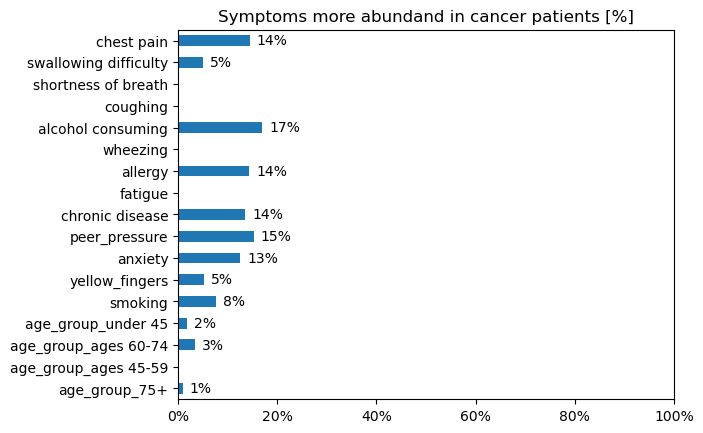

In [36]:
#First let's see after SMOTE and Feature Engineering which symptoms are more abundand in the cancer group 

#How much more people suffer from symptoms in the cancer group SMOTE dataset
features_and_target_train = features_train_ohe.copy()
features_and_target_train["lung_cancer"] = target_train #fuse lung cancer to features for complete dataset
data_lung_cancer_positive = features_and_target_train[features_and_target_train["lung_cancer"] ==1] #datapoints with lung cancer
data_lung_cancer_negative = features_and_target_train[features_and_target_train["lung_cancer"] ==0] #datapoints without lung cancer

#compute how symptoms are more abundand in the cancer group by substracting the percent values of the cancer free group. Symptoms also occuring by the cancer free group can roughly be seen as normal. 
#(Note: There is probably a bias as the cancer free group are presumably not random people from the street but people with symptoms coming to the hospital for a check up)

cancer_to_no_cancer = data_lung_cancer_positive.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"] - data_lung_cancer_negative.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"]

bars = cancer_to_no_cancer.plot(kind="barh", xlim=(0,1))
plt.title("Symptoms more abundand in cancer patients [%]")

for bar in bars.patches:
    plt.annotate(f'{bar.get_width():.0%}',                            
                 xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),  
                 xytext=(5, 0),                                       
                 textcoords='offset points',
                 ha='left', va='center',                              
                 fontsize=10, color='black')

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1)) 



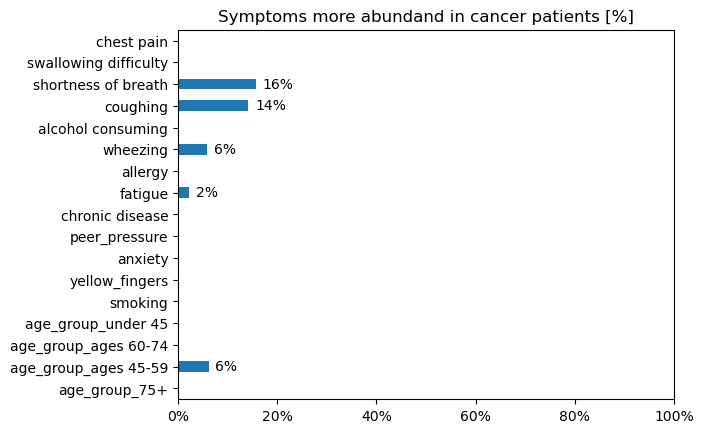

In [37]:
#symptoms more abundand in the no cancer group SMOTE dataset
cancer_to_no_cancer_reverse = data_lung_cancer_negative.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"] - data_lung_cancer_positive.describe().T.drop(["age", "gender", "lung_cancer"]).loc[:,"mean"] 

bars = cancer_to_no_cancer_reverse.plot(kind="barh", xlim=(0,1))
plt.title("Symptoms more abundand in cancer patients [%]")

for bar in bars.patches:
    plt.annotate(f'{bar.get_width():.0%}',                            
                 xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),  
                 xytext=(5, 0),                                       
                 textcoords='offset points',
                 ha='left', va='center',                              
                 fontsize=10, color='black')

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1)) 

In [38]:
#Generate age groups and OHE
features_test_ohe = feature_engineering(features_test)

In [39]:
#Train logistic regression model
#features for training
feature_list = [ "swallowing difficulty", "yellow_fingers",
                "alcohol consuming", "allergy", 
                  "wheezing", "fatigue", "age_group_ages 45-59"] 

features_train_log = features_train_ohe.loc[:,feature_list]
model_log = LogisticRegression(solver = "lbfgs", max_iter=1000, C=4, random_state=42) 
model_log.fit(features_train_log, target_train)

#Crossvalidation to for more reliable estimate of model's performance
cv_logrreg = cross_val_score(model_log, features_train_log, target_train, scoring="accuracy", cv=5)
print("CrossValScore: " ,cv_logrreg.mean())

#Testdataset with selected features
features_test_log = features_test_ohe.loc[:,feature_list]
#Evaluate regression model
eval_regression(model_log, features_test_log, target_test)


CrossValScore:  0.844399460188934
Precision Score:  0.9577464788732394
Recall Score:  0.9714285714285714
Accuracy Score:  0.9397590361445783
F1 Score:  0.9645390070921985


array([[10,  3],
       [ 2, 68]], dtype=int64)

## Story Telling

In [ ]:
Für das Model sind die folgenden Symptomatiken am wichtigsten, um zu unterscheiden, ob Krebs vorliegt. 
"swallowing difficulty" (Rauchen kann auch zu Kehlkopfkrebs führen was Probleme beim Schlucken hervorrufen kann), 
"yellow_fingers", Kommen vor allem nach längerer Zeit des Rauchens und sind demnach als ein indirektes Maß zu sehehn, für wie lange jemand raucht
"alcohol consuming" Rauchen und Alkohol sind beide Teil eines ungesunden Lebensstils.  
"allergy", Fördert rauchen allergien?
"wheezing" War in der nicht krebs gruppe höher, spricht dafür dass die "kontrollgruppe" nicht gesund war sondern wegen beschwerden ins KH ist
"fatigue", War in der nicht krebs gruppe höher, spricht dafür dass die "kontrollgruppe" nicht gesund war sondern wegen beschwerden ins KH ist



Alter war ungleichmäßig im Datensatz verteilt. Under 45 nur 3 Personen und 75+ nur 16. 
"age_group_ages 45-59" war häufiger bei nicht krebs vertreten. Spekulation
Die meisten Lungenkrebsdiagnosen gibt es mit 65 https://www.mediclin.de/ratgeber-gesundheit/herz-lunge/bronchialkarzinom-lungenkrebs-symptome-ursachen-behandlung-lebenserwartung/#diagnostik-therapie
